In [1]:
import cv2
import numpy as np
import pandas as pd
from aeon.analysis.movies import *
from aeon.analysis.utils import *
from aeon.analysis.plotting import *
import aeon.io.api as aeon
import aeon.io.video as video
import matplotlib.pyplot as plt
from aeon.schema.dataset import exp02
from functools import partial

In [75]:
dpi = 300
output = 'figures'
plt.rcParams.update({'font.size': 22})
root = '/ceph/aeon/aeon/data/raw/AEON2/experiment0.2'
subjectState = aeon.load(root, exp02.ExperimentalMetadata.SubjectState)         # load all sessions

In [43]:
prefix = 'BAA-1100703'
events = subjectState[subjectState.id == prefix]                         # take only sessions from specific mouse
sessions = visits(events, onset='Enter', offset='Exit')                         # compute session duration
sessions

,id,weight_enter,weight_exit,enter,exit,duration
0,BAA-1100703,30.3,29.5,2022-05-25 08:59:51.050459862,2022-06-06 07:55:37.501309872,11 days 22:55:46.450850010


In [4]:
session = sessions.iloc[0]                                                     # pick a session
enter, exit = session.enter, session.exit                                      # get session start and end           
prefix = '{0}_{1}'.format(session.id, enter.date())                            # format figure prefix
sessiondata = partial(aeon.load, root, start=enter, end=exit)                  # get session data loader between start and end

In [7]:
pellets1 = sessiondata(exp02.Patch1.DeliverPellet)                # get pellet events for patch1
pellets2 = sessiondata(exp02.Patch2.DeliverPellet)                # get pellet events for patch2
state1 = sessiondata(exp02.Patch1.DepletionState)                 # get patch state for patch1 between start and end
state2 = sessiondata(exp02.Patch2.DepletionState)                 # get patch state for patch2 between start and end


<AxesSubplot:xlabel='trials', ylabel='iti (seconds)'>

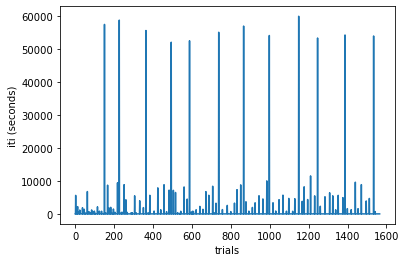

In [28]:
trial2 = state2.reset_index()
trial2['iti'] = trial2.time.diff().dt.total_seconds()
trial2.iti.plot(xlabel='trials', ylabel='iti (seconds)')

In [85]:
tstart = trial2.iloc[179].time
tend = trial2.iloc[181].time
# tstart, tend = trial_0.time, trial_1 + pd.Timedelta(60, 's')
trialdata = partial(aeon.load, root, start=tstart, end=tend)                  # get trial data loader between start and end

In [86]:
position = trialdata(exp02.CameraTop.Position)                  # get position data
encoder2 = trialdata(exp02.Patch2.Encoder)                      # get encoder data for patch2
wheel2 = distancetravelled(encoder2.angle)                      # compute total distance travelled on patch2 wheel
frames = trialdata(exp02.CameraPatch2.Video)                    # get side view for patch2

In [53]:
# clips = triggerclip(frames, pellets2, before='5s', after='10s')
# movie = gridmovie(clips, 640, 1800, (5, 1))
# video.export(movie, '{0}-in_patch2.avi'.format(prefix), 60)

In [79]:
from exp02_patchmovies import wheelmovie
movie = wheelmovie(frames, pellets2, wheel2)
video.export(movie, '{0}-in_patch2-single-trial.avi'.format(prefix), 60)

In [102]:
fig = plt.figure()
fig.set_size_inches(19.2, 14.4)
gs = fig.add_gridspec(3, 1)
frame_ax = fig.add_subplot(gs[0:2,0])
wheel_ax = fig.add_subplot(gs[2, 0])
movie = video.frames(frames)

signal = wheel2 * 0.01
motion = (signal.rolling('8ms').mean()).reindex(frames.index, method='pad')
wheel_ax.plot((motion.index-motion.index[0]).total_seconds(), motion, 'b')
ymin, ymax = wheel_ax.get_ylim()
xmin, xmax = wheel_ax.get_xlim()

writer = None
for i, frame in enumerate(movie):
    wheel_ax.clear()
    frame_ax.clear()
    frame_ax.imshow(frame)
    frame_ax.set_axis_off()
    
    wheel_ax.plot((motion.index-motion.index[0]).total_seconds(), motion, 'b')
    wheel_ax.vlines((motion.index[i]-motion.index[0]).total_seconds(), ymin, ymax, 'r')
    wheel_ax.hlines(1, xmin, xmax, 'k', 'dashed')

    wheel_ax.set_ylim(ymin,ymax)
    wheel_ax.set_ylabel('distance travelled (m)')
    wheel_ax.set_xlabel('time (s)')
    plt.tight_layout()
    fig.subplots_adjust(left=0.2,right=0.8)
    
    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    img = np.frombuffer(fig.canvas.buffer_rgba(), np.uint8).reshape(h, w, -1)
    img = cv2.cvtColor(img, cv2.cv2.COLOR_RGBA2BGR)

    if writer is None:
        fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
        writer = cv2.VideoWriter('{0}-in_patch2-single-trial.avi'.format(prefix),fourcc,60, (img.shape[1], img.shape[0]))
    writer.write(img)
writer.release()
plt.close(fig)